# Init

In [1]:
from __future__ import absolute_import, division, print_function

import logging
import sys

logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import os
import numpy as np
from modules import utils, feature_extraction as fe, postprocessing as pp, visualization
import modules.data_generation as data_generation
from modules.data_generation import DataGenerator
from modules import filtering, data_projection as dp
import matplotlib.pyplot as plt

logger = logging.getLogger("dataGenNb")


## Generate data 

Data should be in an appropriate format and filtered before when we load it here. It does not have to be scaled. 

In [42]:
dg = DataGenerator(natoms=10, nclusters=2, natoms_per_cluster=[1, 1, 1, 1, 1, 1, 1], nframes_per_cluster=1000, 
                   noise_level=0.01, #1e-2, #1e-2, 
                   displacement=0.1, 
                   noise_natoms=None,
                   feature_type='carteesian_rot', #carteesian_rot_trans
                   test_model='linear') 
#dg.generate_frames()
#dg.generate_clusters()
dg.select_atoms_to_move()
data, labels = dg.generate_frames()
cluster_indices = labels.argmax(axis=1)
feature_to_resids = dg.feature_to_resids()
logger.info("Generated data of shape %s and %s clusters", data.shape, labels.shape[1])

2019-01-22 16:18:02 dataGen-INFO: Selecting atoms to be moved ...
2019-01-22 16:18:02 dataGen-INFO: Generating frames ...
2019-01-22 16:18:02 dataGenNb-INFO: Generated data of shape (2000, 30) and 2 clusters


## Sneak peek the clusters

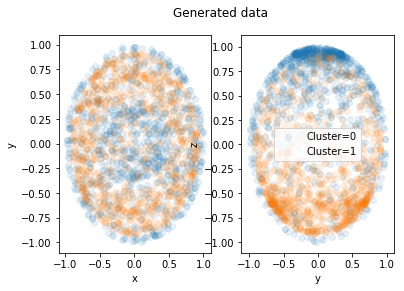

In [43]:
#Only for feature_type == 'cartesian'
def plot_carteesian_features(data, dg, title=None):
    if 'carteesian' not in dg.feature_type:
        logger.warn("No carteesian features")
        return
    gix, [xy_ax, yz_ax] = plt.subplots(1,2)
    for ni in range(dg.nclusters):
        xy_ax.scatter(data[ni::dg.nclusters,3*dg.moved_atoms[ni][0]], 
                    data[ni::dg.nclusters,3*dg.moved_atoms[ni][0]+1], 
                    label="Cluster=%s"%ni, alpha=0.1)    
        yz_ax.scatter(data[ni::dg.nclusters,3*dg.moved_atoms[ni][0] + 1], 
                    data[ni::dg.nclusters,3*dg.moved_atoms[ni][0]+ 2], 
                    label="Cluster=%s"%ni, alpha=0.1)

    plt.legend()
    xy_ax.set_xlabel("x")
    xy_ax.set_ylabel("y")
    yz_ax.set_xlabel("y")
    yz_ax.set_ylabel("z")
    #plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_carteesian_features(data, dg, title="Generated data")

## Define the different methods to use

Every method is encapsulated in a so called FeatureExtractor class which all follow the same interface

In [29]:
n_iterations, n_splits = 1,1 
filter_by_distance_cutoff = False 
feature_extractors = [
#      fe.MlpFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, #hidden_layer_sizes=(dg.natoms, dg.nclusters*2), 
#                            training_max_iter=10000, 
#                            activation="logistic", 
#                           filter_by_distance_cutoff=filter_by_distance_cutoff), #, solver="sgd"),
     fe.MlpAeFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, 
                           hidden_layer_sizes=(int(data.shape[1]/2),), 
                           training_max_iter=10000, 
                           activation="relu"), #, solver="sgd"),    
    fe.RbmFeatureExtractor(data, cluster_indices, 
                           n_splits=n_splits,
                           n_iterations=n_iterations, 
                           n_components=dg.nclusters, 
                           filter_by_distance_cutoff=filter_by_distance_cutoff),
#     fe.ElmFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, 
#                            activation="logistic",
#                            n_nodes=3*dg.nfeatures, 
#                            alpha=1,
#                            filter_by_distance_cutoff=filter_by_distance_cutoff),
#     fe.KLFeatureExtractor(data, cluster_indices, n_splits=n_splits, 
#                            filter_by_distance_cutoff=filter_by_distance_cutoff),
     fe.PCAFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_components=None,
                                filter_by_distance_cutoff=filter_by_distance_cutoff),
    fe.RandomForestFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations,
                                                               filter_by_distance_cutoff=filter_by_distance_cutoff),
]
logger.info("Done. using %s feature extractors", len(feature_extractors))


2019-01-22 16:13:44 mlp-DEBUG: Initializing MLP with the following parameters:                       n_splits 1, n_iterations 1, scaling True, filter_by_distance_cutoff False, contact_cutoff 0.5,                       hidden_layer_sizes (22,), solver lbfgs, activation function logistic, randomize True, training_max_iter 10000
2019-01-22 16:13:44 rbm-DEBUG: Initializing RBM with the following parameters:                       n_splits 1, n_iterations 1, scaling True, filter_by_distance_cutoff False, contact_cutoff 0.5,                       n_components 2, randomize True, method from_lrp
2019-01-22 16:13:44 PCA-DEBUG: Initializing PCA with the following parameters:                       n_splits 1, scaling True, filter_by_distance_cutoff False, contact_cutoff 0.5,                       n_components None
2019-01-22 16:13:44 RF-DEBUG: Initializing RF with the following parameters:                       n_splits 1, n_iterations 1, scaling True, filter_by_distance_cutoff False, contact_cuto

In [30]:
results = []
for extractor in feature_extractors:
    extractor.error_limit = 500
    logger.info("Computing relevance for extractors %s", extractor.name)
    feature_importance, std_feature_importance, errors = extractor.extract_features()
    #logger.info("Get feature_importance and std of shapes %s, %s", feature_importance.shape, std_feature_importance.shape)
    results.append((extractor, feature_importance, std_feature_importance, errors))
logger.info("Done")


2019-01-22 16:13:45 dataGenNb-INFO: Computing relevance for extractors MLP_AE
2019-01-22 16:13:45 Extracting features-INFO: Performing feature extraction with MLP_AE on data of shape (2000, 45)
2019-01-22 16:13:45 Extracting features-INFO: Using all data in training and validation sets
2019-01-22 16:13:45 mlp_ae-DEBUG: Training MLP with 2000 samples and 45 features ...
2019-01-22 16:14:19 mlp_ae-DEBUG: Extracting feature importance using MLP Autoencoder ...
2019-01-22 16:14:19 mlp-DEBUG: Extracting feature importance using MLP ...
2019-01-22 16:14:19 mlp-DEBUG: Rescaling feature importance extracted using MLP in each frame between min and max ...
2019-01-22 16:14:19 Extracting features-INFO: Done with MLP_AE
2019-01-22 16:14:19 Extracting features-INFO: ------------------------------
2019-01-22 16:14:19 dataGenNb-INFO: Computing relevance for extractors RBM
2019-01-22 16:14:19 Extracting features-INFO: Performing feature extraction with RBM on data of shape (2000, 45)
2019-01-22 16:14:

# Postprocess results to get average features

In [31]:
postprocessors = []
for (extractor, feature_importance, std_feature_importance, errors) in results:
    p = pp.PostProcessor(extractor, feature_importance, std_feature_importance, errors, cluster_indices,
                                     working_dir=None, feature_to_resids=feature_to_resids, 
                                     filter_results=False,
                                     #filter_results_by_cutoff=False,
                                     predefined_relevant_residues=dg.moved_atoms)
    p.average()
    postprocessors.append(p)

logger.info("Done")


2019-01-22 16:14:20 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:20 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:20 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:20 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:20 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:20 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:20 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:20 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:20 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:20 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:20 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:20 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:20 dataGenNb-INFO: Done


# Evaluate results

## Find top ranked residues

2019-01-22 16:14:20 dataGenNb-INFO: Actual atoms moved: [5, 6].
(Cluster generation method linear. Noise level=0.01, displacement=0.1. frames/cluster=1000)
2019-01-22 16:14:20 dataGenNb-INFO: Moved atoms for MLP_AE: [1, 8] (0/2 correct)
2019-01-22 16:14:20 dataGenNb-INFO: Moved atoms for RBM: [5, 6] (2/2 correct)
2019-01-22 16:14:20 dataGenNb-INFO: Moved atoms for PCA: [1, 6] (1/2 correct)
2019-01-22 16:14:20 dataGenNb-INFO: Moved atoms for RF: [5, 6] (2/2 correct)


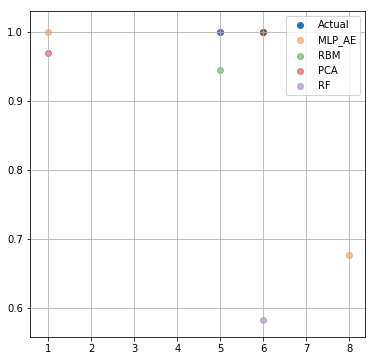

In [32]:

def show_moved_atoms(dg, postprocessors):
    actual_moved_atoms = [a for [a] in sorted(dg.moved_atoms)]
    plt.figure(figsize=(6,6))
    yvalues = np.zeros(len(dg.moved_atoms)) + 1
    plt.scatter(dg.moved_atoms, yvalues, label="Actual")
    logger.info("Actual atoms moved: %s.\n(Cluster generation method %s. Noise level=%s, displacement=%s. frames/cluster=%s)", 
            actual_moved_atoms, 
            dg.test_model, dg.noise_level, dg.displacement, dg.nframes_per_cluster)
    for pp in postprocessors:
        #Get most relevant atoms, not that they are not sorted
        label=pp.extractor.name
        moved_atoms = np.argpartition(pp.importance_per_residue, -dg.nclusters)[-dg.nclusters:]
        importance_moved_atoms = pp.importance_per_residue[moved_atoms]
        plt.scatter(moved_atoms, importance_moved_atoms, label=label, alpha=0.5)
        ncorrect = len([a for a in moved_atoms if a in actual_moved_atoms])
        logger.info("Moved atoms for %s: %s (%s/%s correct)", label, sorted(moved_atoms), ncorrect, len(actual_moved_atoms) )
    plt.legend()
    plt.grid()
    plt.show()
    
show_moved_atoms(dg, postprocessors)    

# Remap results

In [33]:
postprocessors = []
filter_results = True
for (extractor, feature_importance, std_feature_importance, errors) in results:
    p = pp.PostProcessor(extractor, feature_importance, std_feature_importance, errors, cluster_indices,
                                     ".", 
                                     pdb_file=None,
                                     feature_to_resids=feature_to_resids, 
                                     filter_results=filter_results)
    p.average()
    p.evaluate_performance()
    #p.persist()
    postprocessors.append([p])
logger.info("Done")


2019-01-22 16:14:20 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:20 filtering-INFO: Filtering feature importances by median ...
2019-01-22 16:14:20 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:20 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:20 projection-INFO: Scoring raw projections.
2019-01-22 16:14:23 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:23 filtering-INFO: Filtering feature importances by median ...
2019-01-22 16:14:23 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:23 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:23 projection-INFO: Scoring raw projections.
2019-01-22 16:14:24 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:24 filtering-INFO: Filtering feature importances by median ...
2019-01-22 16:14:24 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:24 utils-INFO: Rescaling feature importances ...
2019-01-22 16:14:24 projection-INFO: Scori

# Visualize

2019-01-22 16:14:26 dataGenNb-INFO: Actual atoms moved: [[5], [6]].
(Cluster generation method linear. Noise level=0.01, displacement=0.1. frames/cluster=1000)
2019-01-22 16:14:26 utils-INFO: Rescaling feature importances ...


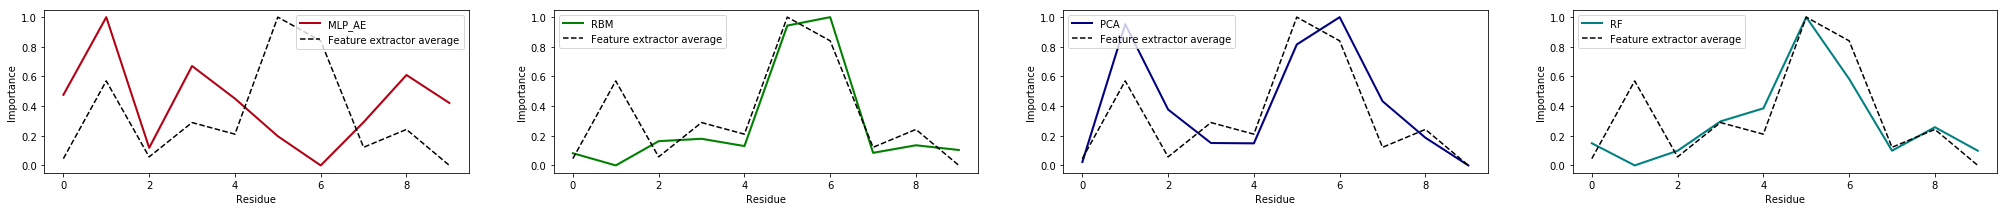

2019-01-22 16:14:26 dataGenNb-INFO: Done. The settings were n_iterations, n_splits = 1, 1.
Filtering (filter_by_distance_cutoff = False)


In [34]:
logger.info("Actual atoms moved: %s.\n(Cluster generation method %s. Noise level=%s, displacement=%s. frames/cluster=%s)", 
            sorted(dg.moved_atoms), 
            dg.test_model, dg.noise_level, dg.displacement, dg.nframes_per_cluster)
visualization.visualize(postprocessors,
          show_importance=True, 
          show_performance=False, 
          show_projected_data=False)

logger.info("Done. The settings were n_iterations, n_splits = %s, %s.\nFiltering (filter_by_distance_cutoff = %s)", 
            n_iterations, n_splits, filter_by_distance_cutoff)

# Experimental

## Simple autoencoder

In [46]:
import sklearn.neural_network
samples = utils.scale(data)
nhidden_nodes = int(samples.shape[1]/2)
classifier = sklearn.neural_network.MLPRegressor(
    hidden_layer_sizes=(nhidden_nodes, samples.shape[1]),
    activation="relu",
    verbose=False
)
classifier.fit(samples, samples)
decoded_samples = classifier.predict(samples)

plot_carteesian_features(samples, dg, title="samples")
plot_carteesian_features(decoded_samples, dg, title="decoded samples")

KeyboardInterrupt: 

## Autoencoder md trajectory
### Load data and look at it

2019-01-22 17:24:13 dataGenNb-DEBUG: Scaling data of shape (1293, 852)


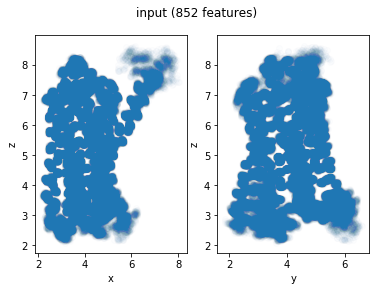

In [185]:
def show_protein(data, title=None, alpha=0.01):
    gix, [xy_ax, yz_ax] = plt.subplots(1,2)
    gix.suptitle(title)
    xy_ax.scatter(data[:,0::3], data[:,2::3], alpha=alpha)
    xy_ax.set_xlabel("x")
    xy_ax.set_ylabel("z")
    yz_ax.scatter(data[:,1::3], data[:,2::3], alpha=alpha)
    yz_ax.set_xlabel("y")
    yz_ax.set_ylabel("z")
    plt.show()
import mdtraj as md
from sklearn.preprocessing import MinMaxScaler

traj = md.load("/home/oliverfl/projects/gpcr/temp_trajs/asp79-apo-swarms-nolipid.xtc", 
          top="/home/oliverfl/projects/gpcr/temp_trajs/asp79-apo-swarms-nolipid.pdb")

##data, _ = md.compute_contacts(traj, scheme="ca")
q="protein or resname 'SOD'"
q="protein and name CA"
data = traj.xyz[:,traj.top.select(q)]
ndata = np.empty((data.shape[0], 3*data.shape[1]))
#flatten matrix
ndata[:,0::3] = data[:,:,0]
ndata[:,1::3] = data[:,:,1]
ndata[:,2::3] = data[:,:,2]
data = ndata
logger.debug("Scaling data of shape %s", data.shape)
scaler = MinMaxScaler()
scaler.fit(data)
samples = scaler.transform(data)
train_step=2
show_protein(scaler.inverse_transform(samples[::train_step]), title="input ({} features)".format(samples.shape[1]))

### Encode data

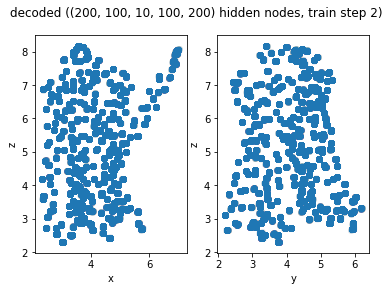

2019-01-22 18:03:11 relevance_propagation-DEBUG: Done


In [210]:
hidden_layer_sizes=(200, 100, 10, 100, 200) #, samples.shape[1]),
#hidden_layer_sizes=(int(samples.shape[1]/2000)) #, samples.shape[1]),
classifier = sklearn.neural_network.MLPRegressor(
    hidden_layer_sizes=hidden_layer_sizes,
    activation="relu",
    verbose=False
)
classifier.fit(samples[::train_step], samples[::train_step])
decoded_samples = classifier.predict(samples[1::train_step])

show_protein(scaler.inverse_transform(decoded_samples[::1]), title="decoded ({} hidden nodes, train step {})".format(hidden_layer_sizes, train_step))
logger.debug("Done")

### Do backprop

2019-01-22 18:05:49 relevance_propagation-DEBUG: Extracting feature importance using MLP ...
2019-01-22 18:05:49 relevance_propagation-DEBUG: Rescaling feature importance extracted using MLP in each frame between min and max ...


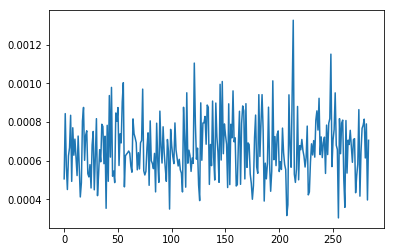

Done


In [216]:
import modules.relevance_propagation as relprop

def _create_layers(classifier, activation="relu"):
    weights = classifier.coefs_
    biases = classifier.intercepts_
    layers = []
    for idx, weight in enumerate(weights):

        if idx == 0:
            l = relprop.FirstLinear(weight, biases[idx])
        elif activation == relprop.relu:
            l = relprop.NextLinear(weight, biases[idx])
        elif activation == relprop.logistic_sigmoid:
            l = relprop.FirstLinear(weight, biases[idx])
        layers.append(l)
        if idx < len(weights) - 1:
            # Add activation to all except output layer
            if activation == relprop.logistic_sigmoid:
                layers.append(relprop.LogisticSigmoid())
            elif activation == relprop.relu:
                layers.append(relprop.ReLU())

    return layers
        
def get_feature_importance(classifier, samples):
    logger.debug("Extracting feature importance using MLP ...")
    layers = _create_layers(classifier)
    # Calculate relevance
    propagator = relprop.RelevancePropagator(layers)
    relevance = propagator.propagate(samples, samples)
    #print(relevance.shape, relevance.max(), relevance.min())
    # Average relevance per cluster
    nclusters = samples.shape[1]
    nfeatures = relevance.shape[1]
    result = np.zeros((nfeatures, nclusters))
    frames_per_cluster = np.zeros((nclusters))

    # Rescale relevance according to min and max relevance in each frame
    logger.debug("Rescaling feature importance extracted using MLP in each frame between min and max ...")
    for i in range(relevance.shape[0]):
        ind_negative = np.where(relevance[i, :] < 0)[0]
        relevance[i, ind_negative] = 0
        relevance[i, :] = (relevance[i, :] - np.min(relevance[i, :])) / (
                np.max(relevance[i, :]) - np.min(relevance[i, :]) + 1e-9)

    for frame_idx, frame in enumerate(labels):
        cluster_idx = labels[frame_idx].argmax()
        frames_per_cluster[cluster_idx] += 1

    for frame_idx, rel in enumerate(relevance):
        cluster_idx = labels[frame_idx].argmax()
        result[:, cluster_idx] += rel / frames_per_cluster[cluster_idx]
    return result.mean(axis=1)

importance = get_feature_importance(classifier, samples)
plt.plot(importance[0::3], '-')
plt.show()
print("Done")